# Adding noise and external catalogues to the architecutre
The referee would like to add noise to the data. This includes
- Galaxy catalogues
- X-ray Catalogues
- Weak lensing maps

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
from globalVariables import *
import simpleCNNwithInception as inceptionCNN
import simpleCNN as simpleCNN
import simpleCNNwithInceptionRegression as regressor
from keras.callbacks import CSVLogger
from scipy.ndimage import rotate
from tools import plot_confusion_matrix
from getSIDMdata_generator_meta import get_tf_DataSet as getGenerators
import scienceplots
from glob import glob
from tools import get_best_model,get_predictions_per_subset,mertens
import os
from scipy.stats import norm
plt.style.use(["science", "grid"])
from copy import deepcopy as cp

### Set things up
- Set up the global stats of noise properties
- Set up the archiecture 
- Plot some examples

#### First some global stats of noise

In [4]:
jwst = { 'total':{'ngal_per_sq_arcmin':100}, \
              'xray':{'exposure_time':10_000},
       'nclusters':8}

euclid  = { 'total':{'ngal_per_sq_arcmin':50}, \
              'xray':{'exposure_time':10_000},
          'nclusters':8}

telescope_name = ['JWST','Euclid']
epochs = 80
telescopes = [jwst, euclid ]

model_name = 'inception'

simulationNames = ['CDM','SIDM0.1','SIDM1']
channels=['total','xray']
nDM_Models = len(simulationNames)

nMonteCarlo = 20

#### How do i concat meta data to the CNN in order to add noise?

In [ ]:
def test_meta( list_of_meta, add_noise=None, verbose=1, epochs=80, channels=['total','xray'], 
              plot_examples=False):
    num_classes = len(simulationNames)
    train, test, params = getGenerators(augment_data=True, simulationNames=simulationNames, 
                                                      channels=channels, 
                                                      allDataFile='pickles/binned_data_20.pkl', 
                                                      random_state=0, return_test_params=True, 
                                                      meta_data=list_of_meta, add_noise=add_noise)
    cnnmodel = mertens.InceptionV4(input_shape=test[0][0][0].shape, bn_momentum=.0,classes=num_classes,
                                               feature_dropout=.33,num_layersA=1,num_layersB=1,num_layersC=1,leak=.03)  
    
    if plot_examples:
        fig, ax = plt.subplots(1, len(channels), figsize=(3*len(channels),3))
        axes = [ax[i].imshow(test[0][0][0,:,:,i]) for i in range(len(channels))]
        plt.show()
        return
    
    shape = test[0][1][0].shape

    input_layer = Input( shape=shape )
    galaxy_model = tf.keras.layers.Flatten( )( input_layer )
    last_layer = cnnmodel.get_layer(cnnmodel.layers[-1].name)

    galaxy_model = tf.keras.layers.Dense(last_layer.output_shape[1])(galaxy_model)
  
    concatenated_model = tf.keras.layers.concatenate( [last_layer.output, galaxy_model], axis=1)
    combine = tf.keras.layers.Dense(128)(concatenated_model)
    out = tf.keras.layers.Dense(num_classes)(combine)
    
    final_model = Model([cnnmodel.input, input_layer], out)  
    
    optimizer = tf.keras.optimizers.Adam( learning_rate=1e-3 ) 
    final_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


    history = final_model.fit(
      x=train,
      validation_data=test,
      epochs=epochs, verbose=verbose )
    
    return final_model, history

#### Now I can concat and add noise, plots examples of noise

Adding noise to : ['total', 'xray']
{'zl': 0.3, 'zs': 2.0, 'ngal_per_sq_arcmin': 50, 'kpc_per_pixel': 20.0, 'ell_disp': 0.3, 'e1_bias': [0.0, 0.0], 'e2_bias': [0.0, 0.0], 'interpolate': True}
{'exposure_time': 1000, 'kpc_per_pixel': 20, 'zl': 0.3}


/Users/davidharvey/Work/darkCNN/lib/python3.10/site-packages/keras/preprocessing/image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (3840, 100, 100, 2) (2 channels).
  warnings.warn(


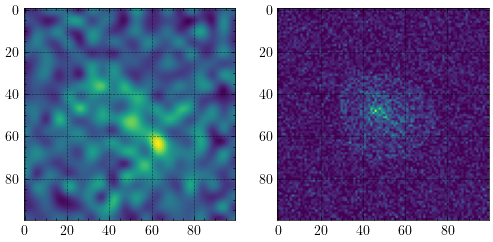

Adding noise to : ['total', 'xray']
{'zl': 0.3, 'zs': 2.0, 'ngal_per_sq_arcmin': 100, 'kpc_per_pixel': 20.0, 'ell_disp': 0.3, 'e1_bias': [0.0, 0.0], 'e2_bias': [0.0, 0.0], 'interpolate': True}
{'exposure_time': 10000, 'kpc_per_pixel': 20, 'zl': 0.3}


/Users/davidharvey/Work/darkCNN/lib/python3.10/site-packages/keras/preprocessing/image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (3840, 100, 100, 2) (2 channels).
  warnings.warn(


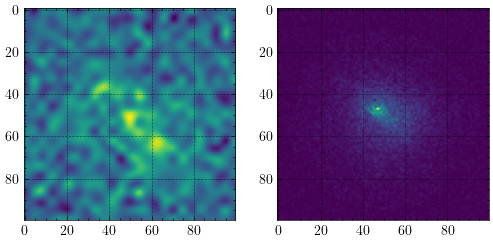

Adding noise to : ['total', 'xray']
{'zl': 0.3, 'zs': 2.0, 'ngal_per_sq_arcmin': 200, 'kpc_per_pixel': 20.0, 'ell_disp': 0.3, 'e1_bias': [0.0, 0.0], 'e2_bias': [0.0, 0.0], 'interpolate': True}
{'exposure_time': 100000, 'kpc_per_pixel': 20, 'zl': 0.3}


/Users/davidharvey/Work/darkCNN/lib/python3.10/site-packages/keras/preprocessing/image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (3840, 100, 100, 2) (2 channels).
  warnings.warn(


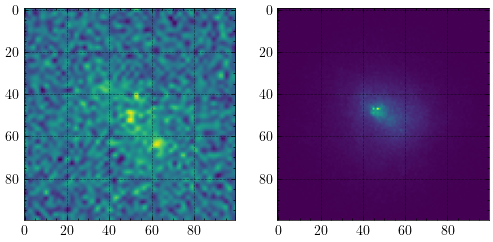

In [247]:
exposure_times = [1_000,10_000,100_000]
gal_densities = [50,100,200]
fileNames=['../plots/low_snr.pdf','../plots/med_snr.pdf','../plots/high_snr.pdf']
for i in range(len(exposure_times)):
    noise = { 'total':{'ngal_per_sq_arcmin':gal_densities[i], 'interpolate':True}, \
              'xray':{'exposure_time':exposure_times[i]}}
    noisy_bcg_shape = test_meta(['bcg_e'],add_noise=noise,  plot_examples=fileNames[i])


### Now to carry out tests on noise components
- Test the external catalogues -> do they impact?
- Test the impact of weak lensing noise
- Test the impact of x-ray noise

#### First different external catalogues including the stellar catalogues

In [ ]:
#get fiducial model
train, test, params = getGenerators(augment_data=True, simulationNames=simulationNames, 
                                                      channels=['total','stellar','xray'], 
                                                      allDataFile='pickles/binned_data_20.pkl', 
                                                      random_state=0, return_test_params=True)
num_classes = len(np.unique(test[1]))
fiducial = mertens.InceptionV4(input_shape=test[0][0].shape, bn_momentum=.0,classes=num_classes,
                                               feature_dropout=.33,num_layersA=1,num_layersB=1,num_layersC=1,leak=.03)  
optimizer = tf.keras.optimizers.Adam( learning_rate=1e-3 ) 
fiducial.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = fiducial.fit(
      x=train,
      validation_data=test,
      epochs=80)

In [ ]:
einstein_rad_with_cats = test_meta(['einstein_rad','bcg_e'])

In [ ]:
einstein_rad = test_meta(['einstein_rad'])

In [ ]:
galaxy_cat = test_meta(['galaxy_catalogues'])

In [ ]:
bcg_conc = test_meta(['BCG_stellar_conc'])

In [ ]:
xray_conc = test_meta(['xrayConc'])

In [ ]:
redshift = test_meta(['redshift'])

In [ ]:
bcg_shape = test_meta(['bcg_e'])

In [ ]:
models =[galaxy_cat, bcg_conc,  xray_conc, redshift, bcg_shape ]
savethese = [ i[0].history.history for i in models ]
pkl.dump(savethese, open("pickles/add_gal_cat.pkl","wb"))

In [ ]:
pkl.dump(models, open("pickles/add_gal_cat.pkl","wb"))

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../plots/add_meta.pdf'.


0

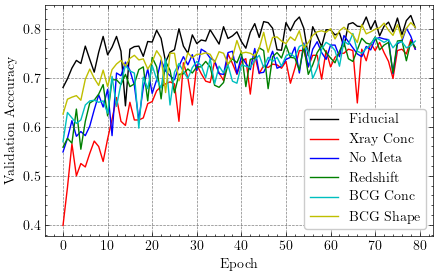

In [243]:
plt.figure(figsize=(5,3))
plt.xlabel('Epoch')
plt.ylabel('Validation Acccuracy')
models = pkl.load(open("pickles/add_gal_cat.pkl","rb"))

c = ['k','r','b','g','c','y','k']
names = ['Fiducial','Xray Conc','No Meta','Redshift','BCG Conc','BCG Shape']
for i, iModel in enumerate(models):
    plt.plot(np.arange(len(iModel['val_accuracy'])), iModel['val_accuracy'], label=names[i], c=c[i])
    #plt.plot(iModel.history.epoch, [np.max(iModel.history.history['val_accuracy'])]*len(iModel.history.epoch), c=c[i])
    #print(np.max(iModel.history.history['val_accuracy']))

plt.legend()
filename="../plots/add_meta.pdf"
plt.savefig(filename)
os.system("pdfcrop %s %s" % (filename, filename))

#### Weak lensing Noise.

In [ ]:
gal_densities =  np.linspace(30,300,14)
model_name = 'inception'

pklfile = "pickles/wl_noise.pkl"
allAcc = []
allProbs = []

for iGalDensity in gal_densities:

    these_noise  = { 'total':{'ngal_per_sq_arcmin':iGalDensity}}
    
    accuracy = []
    probabilities = []
    for iMonteCarlo in range(3,nMonteCarlo):
        train, test, params = getGenerators(augment_data=True, simulationNames=simulationNames, 
                                                      channels=channels, train_split=0.01,
                                                      allDataFile='pickles/binned_data_20.pkl', 
                                                      random_state=iMonteCarlo, return_test_params=True, 
                                                      meta_data=['bcg_e'], add_noise=these_noise)
        
        
        
        checkpoint_filepath = 'models/%s_withcats/%i' % (model_name, iMonteCarlo)
  
        model = get_best_model( train, test, base_cnn_input_shape=test[0][0][0].shape, model_name=model_name, 
                               checkpoint_filepath=checkpoint_filepath, epochs=epochs, meta=['bcg_e'])     
        accuracy.append(model.evaluate(test[0],test[1])[1])
                    
        monte_probabilities = model(test[0])
        
        probabilities.append(monte_probabilities)
    
    allAcc.append(accuracy)
    allProbs.append(probabilities)
    
pkl.dump([allAcc,probabilities],open(pklfile,'wb'))

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../plots/wl_noise.pdf'.


0

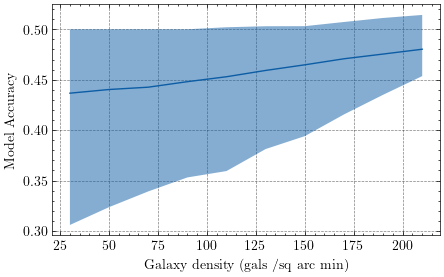

In [261]:
plt.figure(figsize=(5,3))
gal_densities =  np.linspace(30,300,14)

allAcc,probabilities = pkl.load(open("pickles/wl_noise.pkl","rb"))

plt.plot( gal_densities, [ np.mean(i) for i in allAcc])
plt.fill_between( gal_densities, [ np.quantile(i, 0.84)for i in allAcc], [ np.quantile(i, 0.16) for i in allAcc], alpha=0.5)
#plt.plot(gal_densities, allAcc)
plt.xlabel('Galaxy density (gals /sq arc min)')
plt.ylabel('Model Accuracy')
filename="../plots/wl_noise.pdf"
plt.savefig(filename)
os.system("pdfcrop %s %s" % (filename, filename))

#### Xray Noise.


In [ ]:
xray_noisy_models = []
for exposure_time in exposure_times:
    noisy_bcg_shape = test_meta(['bcg_e'],add_noise={'xray':{'exposure_time':exposure_time}}, verbose=1, epochs=50)
    xray_noisy_models.append( noisy_bcg_shape[0].history.history)
pkl.dump(xray_noisy_models, open("pickles/xray_noise.pkl","wb"))

In [ ]:
exposure_times = [1_000,10_000,100_000]
model_name = 'inception'

pklfile = "pickles/xray_noise.pkl"
allAcc = []
allProbs = []

for exposure_time in exposure_times:

    these_noise  = { 'xray':{'exposure_time':exposure_time}}
    
    accuracy = []
    probabilities = []
    for iMonteCarlo in range(3,nMonteCarlo):
        train, test, params = getGenerators(augment_data=True, simulationNames=simulationNames, 
                                                      channels=channels, train_split=0.01,
                                                      allDataFile='pickles/binned_data_20.pkl', 
                                                      random_state=iMonteCarlo, return_test_params=True, 
                                                      meta_data=['bcg_e'], add_noise=these_noise)
        
        
        
        checkpoint_filepath = 'models/%s_withcats/%i' % (model_name, iMonteCarlo)
  
        model = get_best_model( train, test, base_cnn_input_shape=test[0][0][0].shape, model_name=model_name, 
                               checkpoint_filepath=checkpoint_filepath, epochs=epochs, meta=['bcg_e'])     
        accuracy.append(model.evaluate(test[0],test[1])[1])
                    
        monte_probabilities = model(test[0])
        
        probabilities.append(monte_probabilities)
    
    allAcc.append(accuracy)
    allProbs.append(probabilities)
    
pkl.dump([allAcc,probabilities],open(pklfile,'wb'))

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../plots/xray_noise.pdf'.


0

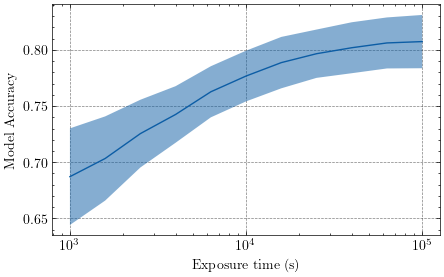

In [255]:
plt.figure(figsize=(5,3))
exposure_times = np.logspace(3,5,11)

allAcc,probabilities = pkl.load(open("pickles/xray_noise.pkl","rb"))

plt.plot( exposure_times, [ np.mean(i) for i in allAcc])
plt.fill_between( exposure_times, [ np.std(i)+np.mean(i) for i in allAcc], [ np.mean(i)-np.std(i) for i in allAcc], alpha=0.5)

plt.xscale('log')
plt.xlabel('Exposure time (s)')
plt.ylabel('Model Accuracy')
filename="../plots/xray_noise.pdf"
plt.savefig(filename)
os.system("pdfcrop %s %s" % (filename, filename))

### Then final predictions
Test for final constraints using
- Weak lensing only
- Weak + Strong (einstein radius) lensing
In this section we look at final predictions, one with weak lensing only, one with weak + strong (einstein radius). Each section contraints three cells.
1. Train Models in the noise free case
2. Get the predictions for the degraded noisey case
3. Plot the predictions

#### Include Strong Lensing

In [ ]:
#Build in an oise free way then degrade the test data not the training data
#monte_carlo_histories = []
nMonteCarlo = 20
start=1
for j in range(start, nMonteCarlo):
    train, test, params = getGenerators(augment_data=True, simulationNames=simulationNames, 
                                                      channels=channels, 
                                                      allDataFile='pickles/binned_data_20.pkl', 
                                                      random_state=j, return_test_params=True, 
                                                      meta_data=['bcg_e','einstein_rad'])
    
    
    
    checkpoint_filepath = 'models/%s_withcats_withein/%i' % (model_name, j)
  
    model = get_best_model( train, test, base_cnn_input_shape=test[0][0][0].shape, model_name=model_name, 
                               checkpoint_filepath=checkpoint_filepath, epochs=epochs, meta=['bcg_e'])
    monte_carlo_histories.append( model.history.history )

    
pkl.dump(monte_carlo_histories, open("pickles/noisefree_withcats_witheinstein_%s_model.pkl" % model_name,"wb"))

In [ ]:
test_simulationNames = ['CDM']
for i, iT in enumerate(telescopes):
    
    pklfile = "pickles/%s_withein.probs" % telescope_name[i]
    accuracy = []
    probabilities = []
    this_telescope = cp(telescopes[i])
    this_telescope['total']['ngal_per_sq_arcmin'] = this_telescope['total']['ngal_per_sq_arcmin']*this_telescope['nclusters']
    this_telescope['xray']['exposure_time'] = this_telescope['xray']['exposure_time']*this_telescope['nclusters']

    for iMonteCarlo in range(nMonteCarlo):
        train, test, params = getGenerators(augment_data=True, simulationNames=test_simulationNames, 
                                                      channels=channels, train_split=0.01,
                                                      allDataFile='pickles/binned_data_20_newseed.pkl', 
                                                      random_state=iMonteCarlo, return_test_params=True, 
                                                      meta_data=['bcg_e','einstein_rad'], add_noise=this_telescope)
        
        
        
        checkpoint_filepath = 'models/%s_withcats_withein/%i' % (model_name, j)
  
        model = get_best_model( train, test, base_cnn_input_shape=test[0][0][0].shape, model_name=model_name, 
                               checkpoint_filepath=checkpoint_filepath, epochs=epochs, meta=['bcg_e'])     
    
        accuracy.append(model.evaluate(test[0],test[1])[1])
                    
        monte_probabilities = model(test[0])
        
        probabilities.append(monte_probabilities)
        
    pkl.dump([probabilities,accuracy],open(pklfile,'wb'))

In [ ]:
c = ['r','b','g','c','purple']
fig = plt.figure(figsize=(5,3))
ax = plt.gca()
total_clusters = [10,1000] #because i have now included nclusters in to the effective galaxy sq arc minute
for i, iT in enumerate(telescopes):
    iSubSample = int(total_clusters[i]/iT['nclusters'])
    pklfile = "pickles/%s_withein.probs" % telescope_name[i]
    probabilities, accuracy = pkl.load(open(pklfile,"rb"))
        
    these_probs = np.exp(np.array(probabilities))
    these_probs = these_probs/np.sum(these_probs,axis=-1)[:,:,np.newaxis]

    prediction, err = get_predictions_per_subset( these_probs, iSubSample, 
                                                 cross_sections=[0.,0.1,1.], 
                                                 return_weights=False)

    
    mean = np.nanmedian(prediction)
    std = np.nanmean(err)#/np.sqrt(len(prediction))
    x = np.linspace(-0.1,0.5,1000)
    pdf = norm.pdf(x, mean, std)
    ax.plot(x, pdf, color=c[i])
    if i == 0:
        ylims = ax.get_ylim()
    #ax.plot([mean-std,mean-std],[0,ylims[1]*1.1],'--', color=c[i])
    #ax.plot([mean,mean],[0,ylims[1]*1.1],'--', color=c[i])
    #ax.plot([mean+std,mean+std],[0,ylims[1]*1.1],'--', color=c[i])
    ax.fill_between( x[ (x > mean-std) & (x < mean+std) ], 
                    np.zeros(len(x[ (x > mean-std) & (x < mean+std) ])),
                    pdf[ (x > mean-std) & (x < mean+std) ], color=c[i], alpha=0.1)
    ax.plot( [mean-std,mean-std],[0,norm.pdf(mean-std, mean, std)], '-',color=c[i], \
            label="%s (n=%i)" % (telescope_name[i], total_clusters[i]) )
    ax.plot( [mean+std,mean+std],[0,norm.pdf(mean+std, mean, std)], '-',color=c[i])
    
#ax.set_ylim(0,12)
ax.set_xlim(-0.02,0.1)
#ax.set_xscale('log')
ylim = ax.get_ylim()
#ax.plot([0.1,0.1],[0,ylim[1]*1.1],'k-',label='Blind Truth')
#ax.plot([1,1],[0,ylim[1]*1.1],'k-',label='Blind Truth')
ax.set_ylim(0,125)
ax.legend(loc=1)
ax.set_xlabel(r'$\sigma_{\rm DM}/m$ [cm$^2$/g]')
ax.set_ylabel(r'$p(\sigma_{\rm DM}/m)$')

plt.savefig("../plots/final_constraints.pdf")


#### Weak Lensing Only

In [ ]:
#Build in an oise free way then degrade the test data not the training data
#monte_carlo_histories = []
nMonteCarlo = 20
start=1
for j in range(start, nMonteCarlo):
    train, test, params = getGenerators(augment_data=True, simulationNames=simulationNames, 
                                                      channels=channels, 
                                                      allDataFile='pickles/binned_data_20.pkl', 
                                                      random_state=j, return_test_params=True, 
                                                      meta_data=['bcg_e'])
    
    
    
    checkpoint_filepath = 'models/%s_withcats/%i' % (model_name, j)
  
    model = get_best_model( train, test, base_cnn_input_shape=test[0][0][0].shape, model_name=model_name, 
                               checkpoint_filepath=checkpoint_filepath, epochs=epochs, meta=['bcg_e'])
    monte_carlo_histories.append( model.history.history )

    
pkl.dump(monte_carlo_histories, open("pickles/noisefree_withcats_%s_model.pkl" % model_name,"wb"))

In [ ]:
test_simulationNames = ['CDM']
for i, iT in enumerate(telescopes):
    
    pklfile = "pickles/%s.probs" % telescope_name[i]
    accuracy = []
    probabilities = []
    this_telescope = cp(telescopes[i])
    this_telescope['total']['ngal_per_sq_arcmin'] = this_telescope['total']['ngal_per_sq_arcmin']*this_telescope['nclusters']
    this_telescope['xray']['exposure_time'] = this_telescope['xray']['exposure_time']*this_telescope['nclusters']

    for iMonteCarlo in range(nMonteCarlo):
        train, test, params = getGenerators(augment_data=True, simulationNames=test_simulationNames, 
                                                      channels=channels, train_split=0.01,
                                                      allDataFile='pickles/binned_data_20_newseed.pkl', 
                                                      random_state=iMonteCarlo, return_test_params=True, 
                                                      meta_data=['bcg_e'], add_noise=this_telescope)
        
        
        
        checkpoint_filepath = 'models/%s_withcats/%i' % (model_name, iMonteCarlo)
  
        model = get_best_model( train, test, base_cnn_input_shape=test[0][0][0].shape, model_name=model_name, 
                               checkpoint_filepath=checkpoint_filepath, epochs=epochs, meta=['bcg_e'])     
    
        accuracy.append(model.evaluate(test[0],test[1])[1])
                    
        monte_probabilities = model(test[0])
        
        probabilities.append(monte_probabilities)
        
    pkl.dump([probabilities,accuracy],open(pklfile,'wb'))

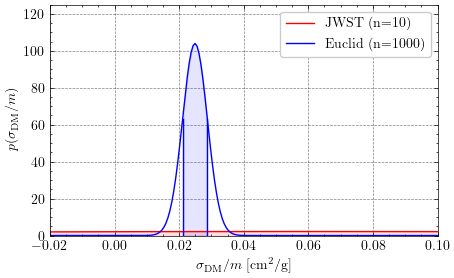

In [262]:
c = ['r','b','g','c','purple']
fig = plt.figure(figsize=(5,3))
ax = plt.gca()
total_clusters = [10,1000] #because i have now included nclusters in to the effective galaxy sq arc minute
for i, iT in enumerate(telescopes):
    iSubSample = int(total_clusters[i]/iT['nclusters'])
    pklfile = "pickles/%s.probs" % telescope_name[i]
    probabilities, accuracy = pkl.load(open(pklfile,"rb"))
        
    these_probs = np.exp(np.array(probabilities))
    these_probs = these_probs/np.sum(these_probs,axis=-1)[:,:,np.newaxis]

    prediction, err = get_predictions_per_subset( these_probs, iSubSample, 
                                                 cross_sections=[0.,0.1,1.], 
                                                 return_weights=False)

    
    mean = np.nanmedian(prediction)
    std = np.nanmean(err)#/np.sqrt(len(prediction))
    x = np.linspace(-0.1,0.5,1000)
    pdf = norm.pdf(x, mean, std)
    ax.plot(x, pdf, color=c[i])
    if i == 0:
        ylims = ax.get_ylim()
    #ax.plot([mean-std,mean-std],[0,ylims[1]*1.1],'--', color=c[i])
    #ax.plot([mean,mean],[0,ylims[1]*1.1],'--', color=c[i])
    #ax.plot([mean+std,mean+std],[0,ylims[1]*1.1],'--', color=c[i])
    ax.fill_between( x[ (x > mean-std) & (x < mean+std) ], 
                    np.zeros(len(x[ (x > mean-std) & (x < mean+std) ])),
                    pdf[ (x > mean-std) & (x < mean+std) ], color=c[i], alpha=0.1)
    ax.plot( [mean-std,mean-std],[0,norm.pdf(mean-std, mean, std)], '-',color=c[i], \
            label="%s (n=%i)" % (telescope_name[i], total_clusters[i]) )
    ax.plot( [mean+std,mean+std],[0,norm.pdf(mean+std, mean, std)], '-',color=c[i])
    
#ax.set_ylim(0,12)
ax.set_xlim(-0.02,0.1)
#ax.set_xscale('log')
ylim = ax.get_ylim()
#ax.plot([0.1,0.1],[0,ylim[1]*1.1],'k-',label='Blind Truth')
#ax.plot([1,1],[0,ylim[1]*1.1],'k-',label='Blind Truth')
ax.set_ylim(0,125)
ax.legend(loc=1)
ax.set_xlabel(r'$\sigma_{\rm DM}/m$ [cm$^2$/g]')
ax.set_ylabel(r'$p(\sigma_{\rm DM}/m)$')

plt.savefig("../plots/final_constraints.pdf")


## Various Systematic Tests

### Photoz Bias

In [ ]:
photo_z_bias = np.linspace(0.8,2.0,10)
model_name = 'inception'

pklfile = "pickles/photoz.probs"
allAcc = []
allProbs = []

for i, iZs in enumerate(photo_z_bias):

    these_noise  = { 'total':{'zs':iZs}}
    
    accuracy = []
    probabilities = []
    for iMonteCarlo in range(3,nMonteCarlo):
        train, test, params = getGenerators(augment_data=True, simulationNames=simulationNames, 
                                                      channels=channels, train_split=0.01,
                                                      allDataFile='pickles/binned_data_20_newseed.pkl', 
                                                      random_state=iMonteCarlo, return_test_params=True, 
                                                      meta_data=['bcg_e'], add_noise=these_noise)
        
        
        
        checkpoint_filepath = 'models/%s_withcats/%i' % (model_name, iMonteCarlo)
  
        model = get_best_model( train, test, base_cnn_input_shape=test[0][0][0].shape, model_name=model_name, 
                               checkpoint_filepath=checkpoint_filepath, epochs=epochs, meta=['bcg_e'])     
        accuracy.append(model.evaluate(test[0],test[1])[1])
                    
        monte_probabilities = model(test[0])
        
        probabilities.append(monte_probabilities)
    
    allAcc.append(accuracy)
    allProbs.append(probabilities)
    
pkl.dump([allAcc,probabilities],open(pklfile,'wb'))

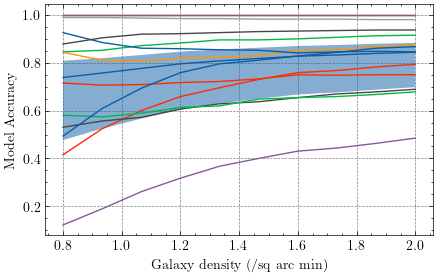

In [126]:
plt.figure(figsize=(5,3))
photo_z_bias = np.linspace(0.8,2.0,10)

allAcc,probabilities = pkl.load(open("pickles/photoz.probs","rb"))

plt.plot( photo_z_bias, [ np.mean(i) for i in allAcc])
plt.fill_between( photo_z_bias, [ np.std(i)/np.sqrt(len(i))+np.mean(i) for i in allAcc], [ np.mean(i)-np.std(i) for i in allAcc], alpha=0.5)
plt.plot(photo_z_bias, allAcc)
plt.xlabel('Galaxy density (/sq arc min)')
plt.ylabel('Model Accuracy')
plt.savefig("../plots/photoz.pdf")

### Ellicipticity bias

In [ ]:
n = 11
bias = np.zeros((n,n,n,n))
#https://academic.oup.com/mnras/article/467/2/1627/2962434
for i, c_e1_bias in tqdm(enumerate(np.linspace(-0.1,0.1,n))):
    for j, m_e1_bias in enumerate(np.linspace(-0.1,0.1,n)):
        for k, c_e2_bias in enumerate(np.linspace(-0.1,0.1,n)):
            for l, m_e2_bias in enumerate(np.linspace(-0.1,0.1,n)):
                
                noisy = add_noise_to_images( test_fid[0][0], params, channels, noise_parameters = {'total':{'ngal_per_sq_arcmin':100,
                                                                                                 'e1_bias':[c_e1_bias, m_e1_bias],
                                                                                                 'e2_bias':[c_e2_bias, m_e2_bias]}})
                
                
                new_test = [ noisy ] + [test_fid[1]]
                

               
                result = noisy_bcg_shape[0].evaluate( new_test, test_fid[1])    
                bias[i,j,k,l] = result[1]
pkl.dump(bias, open("pickles/shape_bias.pkl","wb"))

3445


array([-0.1 , -0.08, -0.1 , -0.08])

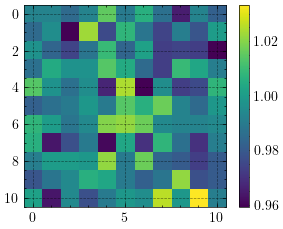

In [221]:
n = 11
thisbias = pkl.load(open("pickles/shape_bias.pkl","rb"))
thisbias /= thisbias[5,5,5,5]
plt.imshow(thisbias[:,:,0,0])
print(np.argmin(thisbias))
plt.colorbar()

pars = np.array([ (i, j, k, l) for i in np.linspace(-0.1,0.1,n)
                 for j in np.linspace(-0.1,0.1,n) 
                 for k in np.linspace(-0.1,0.1,n) 
                 for l in np.linspace(-0.1,0.1,n)])
pars[np.argmax(thisbias)]

Text(0, 0.5, 'Deviation from fiducial')

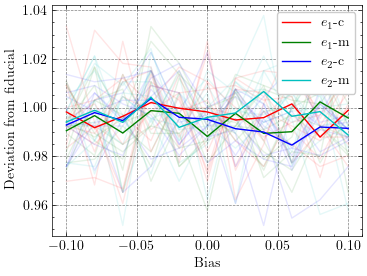

In [228]:
i=-1
plt.figure(figsize=(4,3))

e1cbias, e1mbias, e2cbias, e2mbias = [], [], [], []

for i in range(11):
    plt.plot(np.linspace(-0.1,0.1,n),thisbias[:,i,i,i],c='r', alpha=0.1)
    plt.plot(np.linspace(-0.1,0.1,n),thisbias[i,:,i,i],c='g', alpha=0.1)
    plt.plot(np.linspace(-0.1,0.1,n),thisbias[i,i,:,i],c='b', alpha=0.1)
    plt.plot(np.linspace(-0.1,0.1,n),thisbias[i,i,i,:],c='c', alpha=0.1)
    
    e1cbias.append(thisbias[:,i,i,i])
    e1mbias.append(thisbias[i,:,i,i])
    e2cbias.append(thisbias[i,i,:,i])
    e2mbias.append(thisbias[i,i,i,:])
    

plt.plot( np.linspace(-0.1,0.1,n),np.array(e1cbias).mean(axis=0),'r',label=r'$e_1$-c')   
plt.plot( np.linspace(-0.1,0.1,n),np.array(e1mbias).mean(axis=0),'g',label=r'$e_1$-m')   
plt.plot( np.linspace(-0.1,0.1,n),np.array(e2cbias).mean(axis=0),'b',label=r'$e_2$-c')   
plt.plot( np.linspace(-0.1,0.1,n),np.array(e2mbias).mean(axis=0),'c',label=r'$e_2$-m')   
plt.legend(loc=1)
plt.xlabel("Bias")
plt.ylabel("Deviation from fiducial")